#  How to Make Out-of-Sample Forecasts with ARIMA in Python
- https://machinelearningmastery.com/make-sample-forecasts-arima-python/

After completing this tutorial, you will know:

- How to make a one-step out-of-sample forecast.
- How to make a multi-step out-of-sample forecast.
- The difference between the forecast() and predict() functions.

## 1. Minimum Daily Temperatures Dataset

This dataset describes the minimum daily temperatures over 10 years (1981-1990) in the city of Melbourne, Australia.

The units are in degrees Celsius and there are 3,650 observations. The source of the data is credited as the Australian Bureau of Meteorology.

In [1]:
# line plot of time series
from pandas import Series
from pandas import read_csv
from matplotlib import pyplot

# load dataset
series = read_csv('../input/daily-min-temperatures.csv', header=0, parse_dates=[0], index_col=0)
#series = Series.from_csv('../../input/daily-min-temperatures.csv', header=0)

# display first few rows
#print(series.head(20))

# line plot of dataset
series.plot()
pyplot.show()

<Figure size 640x480 with 1 Axes>

In [2]:
series.head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


In [3]:
series.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3650 entries, 1981-01-01 to 1990-12-31
Data columns (total 1 columns):
Temp    3650 non-null float64
dtypes: float64(1)
memory usage: 57.0 KB


In [4]:
series.describe()

,Temp
count,3650.000000
mean,11.177753
std,4.071837
min,0.000000
25%,8.300000
50%,11.000000
75%,14.000000
max,26.300000


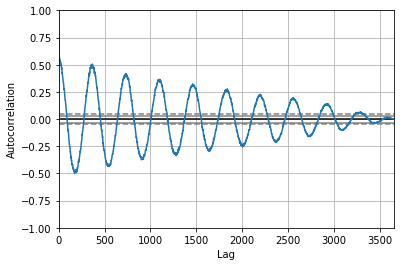

In [5]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series)

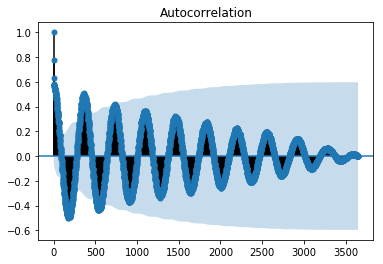

In [6]:
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(series)
pyplot.show()

## 2. Split Dataset

We can split the dataset into two parts.

The first part is the training dataset that we will use to prepare an ARIMA model. The second part is the test dataset that we will pretend is not available. It is these time steps that we will treat as out of sample.

The dataset contains data from January 1st 1981 to December 31st 1990.

We will hold back the last 7 days of the dataset from December 1990 as the test dataset and treat those time steps as out of sample.

In [7]:
split_point = len(series) - 7
dataset, validation = series[0:split_point], series[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
#dataset.to_csv('dataset.csv')
#validation.to_csv('validation.csv')

Dataset 3643, Validation 7


## 3. Develop Model

In this section, we are going to make the data stationary and develop a simple ARIMA model.

The data has a strong seasonal component. We can neutralize this and make the data stationary by taking the seasonal difference. That is, we can take the observation for a day and subtract the observation from the same day one year ago.

This will result in a stationary dataset from which we can fit a model.

In [8]:
import numpy as np

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return np.array(diff)

We can invert this operation by adding the value of the observation one year ago.

We will need to do this to any forecasts made by a model trained on the seasonally adjusted data.

In [9]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

We can fit an ARIMA model.

Fitting a strong ARIMA model to the data is not the focus of this post, so rather than going through the analysis of the problem or grid searching parameters, I will choose a simple ARIMA(7,0,7) configuration.

We can put all of this together as follows:

In [10]:
from statsmodels.tsa.arima_model import ARIMA

# load dataset
series = dataset
#series = Series.from_csv('dataset.csv', header=None)

# seasonal difference
X = series.values
days_in_year = 365
differenced = difference(X, days_in_year)

# fit model
model = ARIMA(differenced, order=(7,0,1))
model_fit = model.fit(disp=0)

# print summary of fit model
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 3278
Model:                     ARMA(7, 1)   Log Likelihood               -8673.748
Method:                       css-mle   S.D. of innovations              3.411
Date:                Mon, 26 Aug 2019   AIC                          17367.497
Time:                        20:47:52   BIC                          17428.447
Sample:                             0   HQIC                         17389.322
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0132      0.132      0.100      0.921      -0.246       0.273
ar.L1.y        1.1426      0.287      3.977      0.000       0.580       1.706
ar.L2.y       -0.4347      0.154     -2.830      0.0

Running the example loads the dataset, takes the seasonal difference, then fits an ARIMA(7,0,7) model and prints the summary of the fit model.

We are now ready to explore making out-of-sample forecasts with the model.

## 4. One-Step Out-of-Sample Forecast

ARIMA models are great for one-step forecasts.

A one-step forecast is a forecast of the very next time step in the sequence from the available data used to fit the model.

### Forecast Function

The statsmodel ARIMAResults object provides a forecast() function for making predictions.

By default, this function makes a single step out-of-sample forecast. As such, we can call it directly and make our forecast. The result of the forecast() function is an array containing the forecast value, the standard error of the forecast, and the confidence interval information. Now, we are only interested in the first element of this forecast, as follows.

In [11]:
# one-step out-of sample forecast
forecast = model_fit.forecast()[0]

Once made, we can invert the seasonal difference and convert the value back into the original scale.

In [12]:
# invert the differenced forecast to something usable
forecast = inverse_difference(X, forecast, days_in_year)

print('Forecast: %f' % forecast)

Forecast: 14.861663


### Predict Function

The statsmodel ARIMAResults object also provides a predict() function for making forecasts.

The predict function can be used to predict arbitrary in-sample and out-of-sample time steps, including the next out-of-sample forecast time step.

The predict function requires a start and an end to be specified, these can be the indexes of the time steps relative to the beginning of the training data used to fit the model, for example:

In [13]:
start_index = '1990-12-25'
end_index = '1990-12-25'
forecast = model_fit.predict(start=start_index, end=end_index)

KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'